In [1]:
%pip install -q "jax[tpu]>=0.2.16" -f https://storage.googleapis.com/jax-releases/libtpu_releases.html
import jax.tools.colab_tpu
jax.tools.colab_tpu.setup_tpu()
jax.devices()

In [2]:
try :
    import flax.linen as nn
except:
    %pip install -q flax
    import flax.linen as nn

from flax.core import unfreeze

from flax.training import train_state 

import jax
import jax.numpy as jnp
from jax.config import config
import optax

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import OffsetImage,AnnotationBbox

from scipy.ndimage import rotate

import tensorflow.keras.datasets as tfds

from functools import partial

     |████████████████████████████████| 197 kB 5.3 MB/s 
     |████████████████████████████████| 216 kB 64.5 MB/s 
     |████████████████████████████████| 140 kB 72.8 MB/s 
     |████████████████████████████████| 51 kB 7.9 MB/s 
     |████████████████████████████████| 72 kB 405 kB/s 


In [3]:
config.update("jax_enable_x64", True)

In [4]:
class LeNet(nn.Module):
    
    @nn.compact
    def __call__(self, x, deterministic):
        
        #1 layer
        x = nn.Conv(features=6, kernel_size=(5,5), name="conv2d_1")(x)
        # x = nn.tanh(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2,2))
        
        #2 layer
        x = nn.Conv(features=16, kernel_size=(5,5), name="conv2d_2")(x)
        # x = nn.tanh(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2,2))
        
        #3 layer
        x = nn.Conv(features=120, kernel_size=(5,5), name="conv2d_3")(x)
        # x = nn.tanh(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2,2))
        
        x = x.reshape((x.shape[0],-1)) #flatten
        #4 fully connected layer
        x = nn.Dense(84, name="Dense_1_84")(x)
        # x = nn.tanh(x)
        x = nn.relu(x)
        x = nn.Dropout(rate=0.5, deterministic= deterministic)(x)

        #5 fully connected layer
        x = nn.Dense(10, name="Dense_2_10")(x)
        # x = nn.softmax(x)
        
        return x


In [5]:
def get_datasets():
    train_dataset, test_dataset = tfds.mnist.load_data()
    X_train, y_train = train_dataset
    x_test, y_test = test_dataset
    
    X_train = jnp.array(X_train/255)
    x_test = jnp.array(x_test/255)
    
    X_train = X_train[..., jnp.newaxis]
    x_test = x_test[..., jnp.newaxis]
    
    return [X_train, jnp.array(y_train)], [x_test, jnp.array(y_test)]


In [6]:
def cross_entropy_loss(params, x, y, deterministic, rng = jax.random.PRNGKey(0)):
    labels_onehot = jax.nn.one_hot(y, num_classes=10)
    logits = model.apply(params, x, deterministic=deterministic, rngs={"dropout": rng})
    return jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=labels_onehot)), logits

In [18]:
def fit(params, X, Y, batch_size, learning_rate=0.001, epochs=10, verbose=False):
    opt = optax.adamw(learning_rate=learning_rate)
    # opt = optax.sgd(learning_rate, 0.75)
    opt_state = opt.init(params)
    
    lg_fn = jax.value_and_grad(cross_entropy_loss, has_aux=True)
    
    rng, _ = jax.random.split(jax.random.PRNGKey(0))
    losses = []

    train_ds_size = len(X)
    steps_per_epoch = train_ds_size // batch_size

    for i in range(epochs):
        rng , _ = jax.random.split(rng)
        @jax.jit
        def one_step(params, x, y, opt_state,rng):
            (loss_val, logits), grads = lg_fn(params, x, y, False, rng = rng)
            updates, opt_state = opt.update(grads, opt_state, params)
            params = optax.apply_updates(params, updates)
            acc_val = jnp.mean(jnp.argmax(logits, -1) == y)
            return params, opt_state, loss_val, logits, acc_val

        # _ , rng = jax.random.split(rng)
        perms = jax.random.permutation(rng, train_ds_size)
        perms = perms[:steps_per_epoch * batch_size]  # skip incomplete batch
        perms = perms.reshape((steps_per_epoch, batch_size))
        accuracy = []
        losses = []

        for perm in perms:
          rng , _ = jax.random.split(rng)
          x, y = X[perm], Y[perm]
          params, opt_state, loss_val, logits, acc_val =  one_step(params, x, y, opt_state, rng)
          losses.append(loss_val)
          accuracy.append(acc_val)

        # if verbose and i % (epochs/10) == 0:
        print('train epoch: %d, loss: %.4f, accuracy: %.2f' % (i, jnp.mean(jnp.array(losses)), jnp.mean(jnp.array(accuracy))))
    return params,losses


In [19]:
train_ds, test_ds = get_datasets()
X_train, y_train = train_ds
x_test, y_test = test_ds

In [20]:
batch = 32
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)
model = LeNet()
params = model.init(init_rng, jnp.ones([1, 28, 28, 1]), deterministic=True)

In [21]:
params, losses = fit(params, X_train, y_train, batch, learning_rate=0.001, epochs = 5)

train epoch: 0, loss: 0.1911, accuracy: 0.94
train epoch: 1, loss: 0.0809, accuracy: 0.98
train epoch: 2, loss: 0.0615, accuracy: 0.98
train epoch: 3, loss: 0.0454, accuracy: 0.99
train epoch: 4, loss: 0.0415, accuracy: 0.99


# Figure

In [28]:
one_img = x_test[2]
one_img = rotate(one_img, 15, reshape=False)

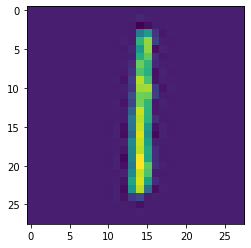

In [29]:
plt.imshow(one_img.squeeze())

In [34]:
imgs = jnp.array([rotate(one_img, 5*i, reshape=False) for i in range(12)])

In [35]:
# for i in imgs:
#   plt.imshow(i.squeeze())
#   plt.show()

In [36]:
pred = model.apply(params, imgs, deterministic=False,  rngs={"dropout": jax.random.PRNGKey(0)})
jnp.argmax(pred,axis=1)

DeviceArray([1, 1, 1, 1, 1, 1, 1, 1, 7, 7, 1, 7], dtype=int64)

# MC Dropout

In [37]:
n_stacks = 100
y_stacks = []
for i in range(n_stacks):
    y_stacks.append(model.apply(params, imgs, deterministic=False, rngs={"dropout": jax.random.PRNGKey(i)}))
y_stacks = jnp.array(y_stacks)

In [38]:
stacks = y_stacks[:,:,(1,5,7)]

In [39]:
mean = stacks.mean(axis=0)
std = stacks.std(axis=0)

In [40]:
def offset_image(coord, i, ax, low_img, low_index):
    img = imgs[i]
    im = OffsetImage(img.squeeze(), zoom=1)
    im.image.axes = ax

    ab = AnnotationBbox(im, (coord, low_img),  xybox=(0., low_index), frameon=False,
                        xycoords='data',  boxcoords="offset points", pad=0)
    ax.add_artist(ab)

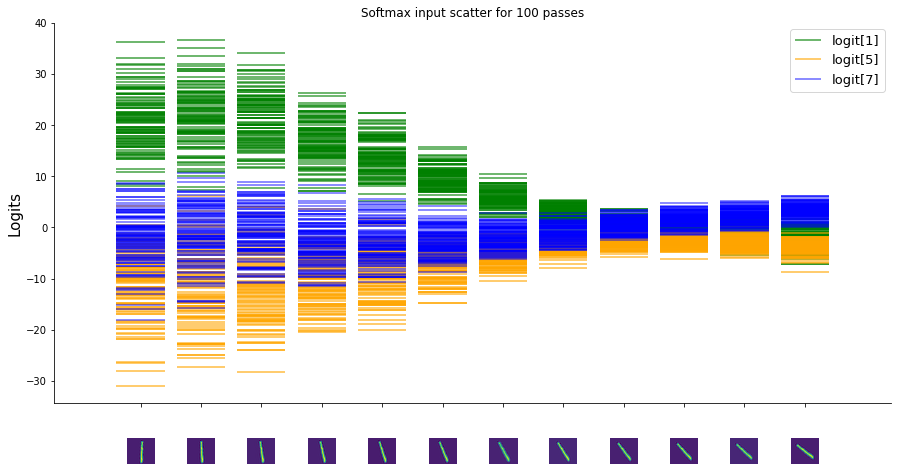

In [41]:
# plt.figure(figsize=(10,6))
fig, ax = plt.subplots(figsize=(15,7))
index = jnp.arange(12)
for i in range(12):
    ax.eventplot(stacks[:,i,0], orientation="vertical", lineoffsets=i, linelengths=0.8, colors="green", alpha=0.75)
    ax.eventplot(stacks[:,i,1], orientation="vertical", lineoffsets=i, linelengths=0.8, colors="orange", alpha=0.75)
    ax.eventplot(stacks[:,i,2], orientation="vertical", lineoffsets=i, linelengths=0.8, colors="blue", alpha=0.6)
    
ax.set_xticks(index)
ax.set_xticklabels(index + 1)
ax.tick_params(axis='x', which='major', pad=40, labelsize=10)
ax.set_ylabel("Logits", fontsize=15)
l, h = ax.get_ylim()
for i in index:
    offset_image(i, i, ax, l, l-15)

plt.legend(["logit[1]","logit[5]","logit[7]"],fontsize=13)
plt.title("Softmax input scatter for 100 passes")
sns.despine()
plt.savefig("Mnist_with_MC_Dropout",quality=100)
plt.show()

In [ ]:
soft_stacks = nn.softmax(stacks,axis=-1)

In [ ]:
soft_mean = soft_stacks.mean(axis=0)
soft_std = soft_stacks.std(axis=0)

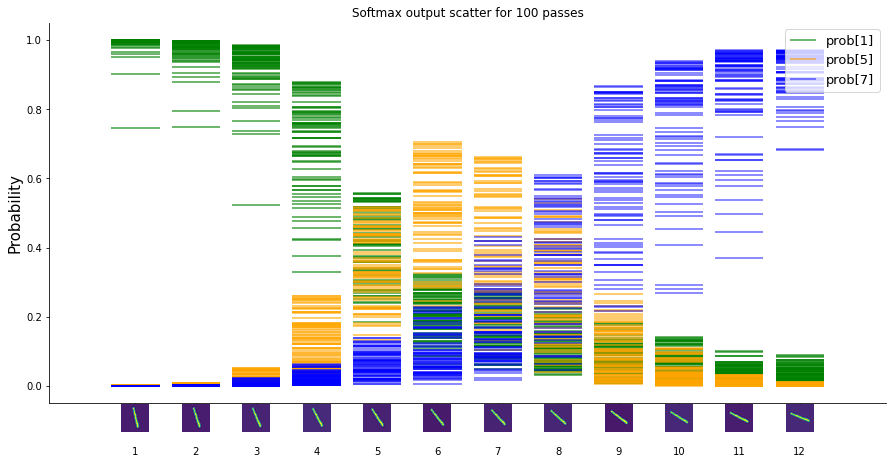

In [ ]:
# plt.figure(figsize=(10,6))
fig, ax = plt.subplots(figsize=(15,7))
index = jnp.arange(12)
for i in range(12):
    ax.eventplot(soft_stacks[:,i,0].sort()[:75], orientation="vertical", lineoffsets=i, linelengths=0.8, colors="green", alpha=0.75)
    ax.eventplot(soft_stacks[:,i,1].sort()[:75], orientation="vertical", lineoffsets=i, linelengths=0.8, colors="orange", alpha=0.75)
    ax.eventplot(soft_stacks[:,i,2].sort()[:75], orientation="vertical", lineoffsets=i, linelengths=0.8, colors="blue", alpha=0.6)
    
ax.set_xticks(index)
ax.set_xticklabels(index + 1)
ax.tick_params(axis='x', which='major', pad=40, labelsize=10)
ax.set_ylabel("Probability", fontsize=15)
l, h = ax.get_ylim()
for i in index:
    offset_image(i, i, ax, l, l-15)

plt.legend(["prob[1]","prob[5]","prob[7]"],fontsize=13)
plt.title("Softmax output scatter for 100 passes")
sns.despine()
plt.savefig("soft_Mnist_with_MC_Dropout",quality=100)
plt.show()

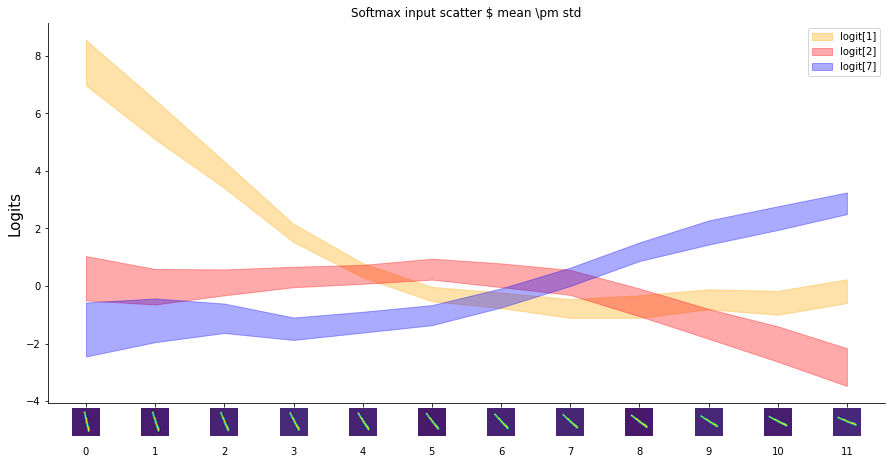

In [ ]:
# plt.figure(figsize=(10,6))
fig, ax = plt.subplots(figsize=(15,7))
index = jnp.arange(12)
ax.fill_between(index, mean[:,0] + 0.5*std[:,0], mean[:, 0] - 0.5*std[:,0], color="orange", alpha = 1/3, label=f"logit[1]")
ax.fill_between(index, mean[:,1] + 0.5*std[:,1], mean[:, 1] - 0.5*std[:,1], color="red", alpha = 1/3, label=f"logit[2]")
ax.fill_between(index, mean[:,2] + 0.5*std[:,2], mean[:, 2] - 0.5*std[:,2], color="blue", alpha = 1/3, label=f"logit[7]")
ax.set_xticks(index)
ax.set_xticklabels(index)
ax.tick_params(axis='x', which='major', pad=40, labelsize=10)
l, h = ax.get_ylim()
for i in index:
    offset_image(i, i, ax, l, l-15)
plt.legend()
plt.title("Softmax input scatter $ mean \pm std")
sns.despine()
ax.set_ylabel("Logits", fontsize=15)
plt.savefig("mnist_mc_dropout_mean_sigma", quality=100)
plt.show()